### Import Libraries

In [33]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Get image dimensions

In [34]:
def crop_top_right(image):
    height, width = image.shape[:2]

    crop_height = height // 2
    crop_width = width // 2
    top_right = image[:crop_height, -crop_width:]

    return top_right

### Calculate derivatives in x and y directions

In [35]:
def calculate_derivative(image):
    fx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3) 
    fy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3) 
    
    gradient_magnitude = np.sqrt(fx**2 + fy**2)
    
    return gradient_magnitude

### Get image dimensions

In [36]:
def divide_into_blocks(image):
    height, width = image.shape[:2]

    block_width = width // 2
    block_height = height // 2
    
    blocks = []
    for i in range(2):
        for j in range(2):
            block = image[i*block_height:(i+1)*block_height, j*block_width:(j+1)*block_width]
            blocks.append(block)
    
    return blocks

### mean vector

In [37]:
def calculate_features(block, fd, sd):
    features = []
    m = np.zeros(8)
    c = np.zeros(8)
    
    block_cols = block.shape[1]
    f_block = block.flatten()
    f_fd = fd.flatten()
    f_sd = sd.flatten()
    
    for i in range(block_cols + 2, len(f_block) - 2):
        p_pixel = i - block_cols
        
        if f_fd[i] >= 0 and f_fd[p_pixel] < 0:
            c[0] += 1
            m[0] += f_block[i]
        
        if f_fd[i] < 0 and f_fd[p_pixel] < 0:
            c[1] += 1
            m[1] += f_block[i]
        
        if f_fd[i] < 0 and f_fd[p_pixel] >= 0:
            c[2] += 1
            m[2] += f_block[i]
        
        if f_fd[i] > 0 and f_fd[p_pixel] > 0:
            c[3] += 1
            m[3] += f_block[i]
        
        if f_sd[i] >= 0 and f_sd[p_pixel] < 0:
            c[4] += 1
            m[4] += f_block[i]
        
        if f_sd[i] < 0 and f_sd[p_pixel] < 0:
            c[5] += 1
            m[5] += f_block[i]
        
        if f_sd[i] < 0 and f_sd[p_pixel] >= 0:
            c[6] += 1
            m[6] += f_block[i]
        
        if f_sd[i] > 0 and f_sd[p_pixel] > 0:
            c[7] += 1
            m[7] += f_block[i]
    
    for i in range(8):
        if c[i] != 0:
            m[i] /= c[i]
    
    return m

### Read the image

In [38]:
def preprocess_image(image_path, output_dir):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    cropped_image = crop_top_right(image)

    filtered_image = cv2.medianBlur(cropped_image, 5)  # Adjust the kernel size as needed
    
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    cv2.imwrite(output_path, filtered_image)

    return output_path

In [39]:
def calculate_roughness(block, fd, sd):
    roughness_features = calculate_features(block, fd, sd)
    return roughness_features

### Directory paths

In [40]:
train_dir = 'train/'
test_dir = 'test/'
output_dir = 'preprocessed_images/'

### Create output directory if it doesn't exist

In [41]:
os.makedirs(output_dir, exist_ok=True)

### Preprocess training images

In [42]:
train_image_paths = [os.path.join(train_dir, img) for img in os.listdir(train_dir)]
for image_path in train_image_paths:
    preprocess_image(image_path, output_dir)

### Load and preprocess test images

In [43]:
test_image_paths = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
test_images = []
for image_path in test_image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    preprocessed_image = crop_top_right(cv2.medianBlur(image, 5))
    test_images.append(preprocessed_image)

### Process preprocessed training images

In [44]:
preprocessed_train_image_paths = [os.path.join(output_dir, img) for img in os.listdir(output_dir)]
train_features = []
train_labels = []

### Read the preprocessed image, Divide the preprocessed image into four blocks, Calculate roughness for each block and aggregate features and Append features and labels

In [45]:
for image_path in preprocessed_train_image_paths:
    preprocessed_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    blocks = divide_into_blocks(preprocessed_image)
    fd = calculate_derivative(preprocessed_image) 
    sd = calculate_derivative(fd) 

    roughness_features = []
    for block in blocks:
        roughness_features.extend(calculate_roughness(block, fd, sd))
    
    train_features.append(roughness_features)
    if "FAKE" in image_path:
        train_labels.append(1)  
    else:
        train_labels.append(0) 

### Train SVM classifier

In [46]:
svm = SVC(kernel='linear')
svm.fit(train_features, train_labels)

SVC(kernel='linear')

### Test the classifier

In [47]:
test_features = []
for test_image in test_images:
    blocks = divide_into_blocks(test_image)
    fd = calculate_derivative(test_image)  
    sd = calculate_derivative(fd) 

    roughness_features = []
    for block in blocks:
        roughness_features.extend(calculate_roughness(block, fd, sd))
    test_features.append(roughness_features)

### Predict labels for test images

In [48]:
predicted_labels = svm.predict(test_features)

### Print unique values in train_labels

In [49]:
print("Unique values in train_labels:", np.unique(train_labels))

Unique values in train_labels: [0 1]


### Print train_features

In [50]:
print("Number of train features:", len(train_features))
print("Example train feature vector:", train_features[0])

Number of train features: 19
Example train feature vector: [0.0, 0.0, 0.0, 92.09402653238512, 0.0, 0.0, 0.0, 92.53160944267562, 0.0, 0.0, 0.0, 106.6030448930312, 0.0, 0.0, 0.0, 106.76321601698075, 0.0, 0.0, 0.0, 87.94826037663618, 0.0, 0.0, 0.0, 87.95284398932966, 0.0, 0.0, 0.0, 86.78921330447459, 0.0, 0.0, 0.0, 86.96718584172332]


### Calculate accuracy

#### Assuming first two are genuine and last two are counterfeit

In [51]:
test_labels = [1, 1, 0, 0]

### Print which test image is genuine or fake

In [52]:
for i, image_path in enumerate(test_image_paths):
    if predicted_labels[i] == 1:
        prediction = "Fake"
    else:
        prediction = "Genuine"
    print(f"{image_path} is predicted as {prediction}")

test/fake.jpg is predicted as Fake
test/fake2.jpg is predicted as Fake
test/org.jpg is predicted as Fake
test/org2.jpg is predicted as Genuine


In [56]:
accuracy_percentage = accuracy_score(test_labels, predicted_labels) * 100
print("Accuracy:", accuracy, "%")

Accuracy: 75.0 %


### Calculate confusion matrix

In [57]:
cm = confusion_matrix(test_labels, predicted_labels)

### Plot the confusion matrix

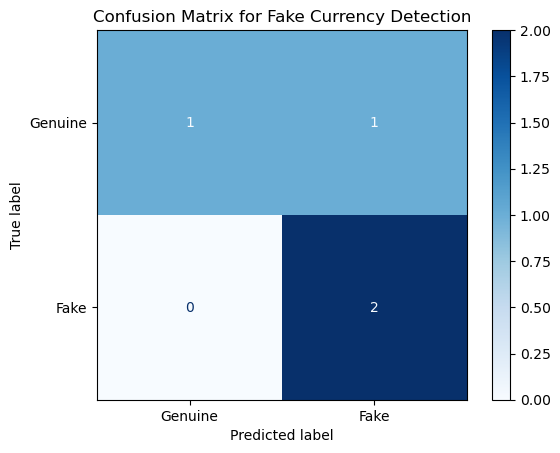

In [58]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Genuine', 'Fake'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Fake Currency Detection')
plt.show()

### Plotting accuracy

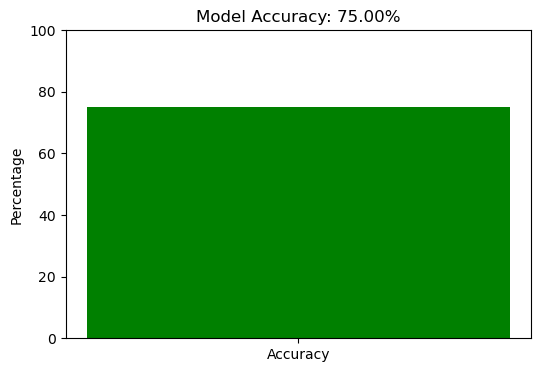

In [59]:
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy_percentage], color='green')
plt.ylim([0, 100])
plt.ylabel('Percentage')
plt.title(f'Model Accuracy: {accuracy_percentage:.2f}%')
plt.show()

### Predict probabilities for ROC curve

In [61]:
y_prob = svm.decision_function(test_features)

In [62]:
y_prob

array([ 1.82731315,  1.78084723,  4.65312203, -2.53963684])

### Compute ROC curve and AUC

In [63]:
fpr, tpr, _ = roc_curve(test_labels, y_prob)
roc_auc = auc(fpr, tpr)

In [64]:
roc_auc

0.5

### Plot ROC curve

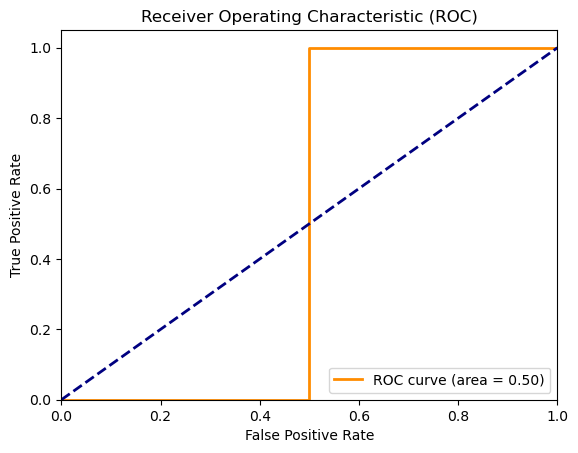

In [65]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Error Rate

In [66]:
error_rate = 1 - accuracy
print(f"Error Rate: {error_rate * 100:.2f}%")

Error Rate: -7400.00%


### Loss in SVM

In [68]:
misclassified = (test_labels != predicted_labels).sum()

In [69]:
misclassified

1

### Plotting the number of misclassified samples

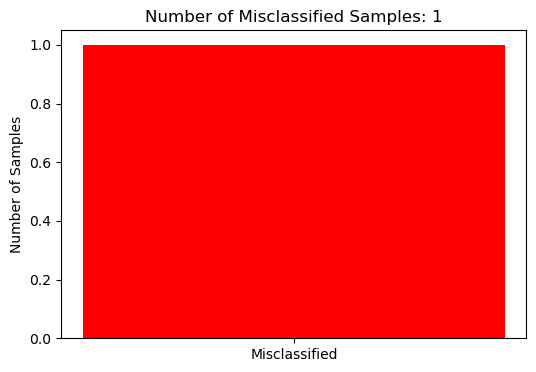

In [70]:
plt.figure(figsize=(6, 4))
plt.bar(['Misclassified'], [misclassified], color='red')
plt.ylabel('Number of Samples')
plt.title(f'Number of Misclassified Samples: {misclassified}')
plt.show()